Using device: cuda
Boundary rows available for Dirichlet: 4062
[1/25000] tot=1.878e+01 data=8.898e-01 phys=2.918e-03 bnd=1.788e+01 SIA_MSE=2.918e-03 STK_MSE=2.918e-03 BND_FLUX_MSE=1.789e-01 lr=3.00e-03
[1000/25000] tot=7.366e+00 data=4.196e-01 phys=1.927e-01 bnd=6.754e+00 SIA_MSE=1.927e-01 STK_MSE=1.927e-01 BND_FLUX_MSE=2.261e+00 lr=2.99e-03
[2000/25000] tot=8.046e+00 data=4.034e-01 phys=6.334e-01 bnd=7.009e+00 SIA_MSE=6.334e-01 STK_MSE=6.334e-01 BND_FLUX_MSE=1.301e+00 lr=2.96e-03
[3000/25000] tot=4.743e+00 data=3.239e-01 phys=4.274e-01 bnd=3.991e+00 SIA_MSE=4.274e-01 STK_MSE=4.274e-01 BND_FLUX_MSE=3.579e+00 lr=2.91e-03
[4000/25000] tot=7.313e+00 data=2.849e-01 phys=3.811e-01 bnd=6.647e+00 SIA_MSE=3.811e-01 STK_MSE=3.811e-01 BND_FLUX_MSE=3.202e+00 lr=2.83e-03
[5000/25000] tot=4.761e+00 data=2.480e-01 phys=2.282e-01 bnd=4.285e+00 SIA_MSE=2.282e-01 STK_MSE=2.282e-01 BND_FLUX_MSE=5.468e+00 lr=2.74e-03
[6000/25000] tot=4.092e+00 data=2.362e-01 phys=5.641e-01 bnd=3.291e+00 SIA_MSE=5.641e-01

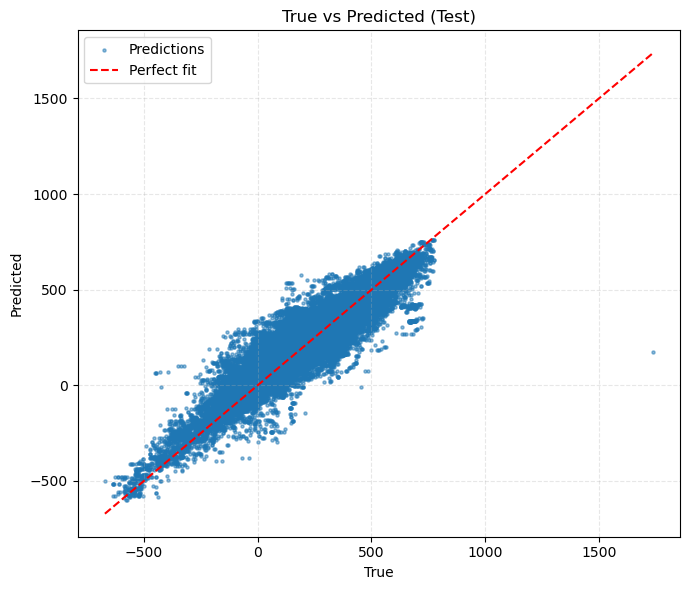

In [ ]:
# ============================================================
# Multi-Fidelity PINN (SIA + reduced Stokes) + Boundary Weak-Form (Dirichlet via NN)
# Single-cell, runnable notebook code

# --------------------------
# Imports & Hyperparameters
# --------------------------
import os, math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt


# ==== HARD DIRICHLET RUN ====
HARD_DIRICHLET = True      # turn on strong/“hard” mode inside BoundaryWeakForm
DIR_FRAC       = 1.0       # label 100% of boundary points as Dirichlet
LAMBDA_DIR     = 1.0       # keep; hard mode will internally scale it (e.g., ×100)
# keep the LAMBDA_NEU as-is for traction/flux

# Toggles and loss weighting strategy
# ------------------------------------------------------------
# NORMALIZE_Y:     If True, target (bed) values are standardized before training.
#
# USE_UNCERTAINTY: If False → use fixed physics weights (W_SIA, W_STK).
#                  If True  → ignore fixed weights and let the model learn
#                  adaptive weights via Kendall's uncertainty weighting
#                  (log-variances clamped by LOG_CLAMP).
#
# W_SIA, W_STK:    Manual weights applied to SIA vs Stokes residuals
#                  when USE_UNCERTAINTY is False.
#
# LAMBDA_NEU, LAMBDA_DIR: Relative weights for Neumann (flux/traction) and Dirichlet boundary losses.

NORMALIZE_Y     = True            # normalize target for training (recommended)
USE_UNCERTAINTY = False           # False: fixed physics weights; True: learned Kendall
LOG_CLAMP       = (-5.0, 5.0)     # clamp if uncertainty weighting enabled

# Physics weights when USE_UNCERTAINTY == False
W_SIA, W_STK    = 0.25, 0.75

# Boundary weights
LAMBDA_NEU, LAMBDA_DIR = 0.1, 0.0

# Boundary weak-form settings
DIR_FRAC         = 0.20            # fraction of boundary points with Dirichlet
HARD_DIRICHLET   = True            # hard Dirichlet where data exist
LAMBDA_NEU       = 0.10            # Neumann weight
LAMBDA_DIR       = 0.10            # Dirichlet weight

# Training schedule
EPOCHS           = 25000           # raise to 20-30k for final runs
HIDDEN           = 128
LR_INIT, LR_MIN  = 3e-3, 3e-4
N_COL_START      = 512
N_COL_END        = 4096
N_BPER           = 96

SEED = 42
torch.manual_seed(SEED); np.random.seed(SEED)

# --------------------------
# Load Data (+ boundary df)
# --------------------------
# try to load from notebook sandbox path first then local
CSV_PATHS = ["/mnt/data/data_full.csv", "data_full.csv"]
csv_path = None
for p in CSV_PATHS:
    if os.path.exists(p):
        csv_path = p
        break
if csv_path is None:
    raise FileNotFoundError("Could not find data_full.csv at /mnt/data/data_full.csv or ./data_full.csv")

df = pd.read_csv(csv_path)

feat_cols  = ['surf_x','surf_y','surf_vx','surf_vy','surf_elv','surf_dhdt','surf_SMB']
target_col = 'track_bed_target'
for c in feat_cols + [target_col]:
    if c not in df.columns:
        raise ValueError(f"Missing required column: {c}")

X_np = df[feat_cols].to_numpy(dtype=np.float32)
y_np = df[target_col].to_numpy(dtype=np.float32).reshape(-1,1)

# 80/20 split
n = len(X_np)
idx = np.random.permutation(n)
split = int(0.8*n)
train_idx, test_idx = idx[:split], idx[split:]
x_train_np, x_test_np = X_np[train_idx], X_np[test_idx]
y_train_np, y_test_np = y_np[train_idx], y_np[test_idx]

# Scale X (+ optionally y)
x_scaler = StandardScaler()
X_train = x_scaler.fit_transform(x_train_np)
X_test  = x_scaler.transform(x_test_np)

if NORMALIZE_Y:
    y_scaler = StandardScaler()
    y_train = y_scaler.fit_transform(y_train_np)
    y_test  = y_scaler.transform(y_test_np)
else:
    y_scaler = None
    y_train, y_test = y_train_np, y_test_np

# Tensors & device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)
X_test_tensor  = torch.tensor(X_test,  dtype=torch.float32, device=device)
y_test_tensor  = torch.tensor(y_test,  dtype=torch.float32, device=device)

# Domain bbox from unscaled surf_x, surf_y
xy_np = df[['surf_x','surf_y']].to_numpy(dtype=np.float32)
xmin, xmax = float(xy_np[:,0].min()), float(xy_np[:,0].max())
ymin, ymax = float(xy_np[:,1].min()), float(xy_np[:,1].max())
bbox = (xmin, xmax, ymin, ymax)

# Build boundary dataframe (data-defined Dirichlet source)
tol_x = 0.001 * (xmax - xmin)  # 0.1% of range tolerance
tol_y = 0.001 * (ymax - ymin)
boundary_mask = (
    (np.isclose(df["surf_x"], xmin, atol=tol_x)) |
    (np.isclose(df["surf_x"], xmax, atol=tol_x)) |
    (np.isclose(df["surf_y"], ymin, atol=tol_y)) |
    (np.isclose(df["surf_y"], ymax, atol=tol_y))
)
boundary_df = df.loc[boundary_mask, ["surf_x","surf_y","track_bed_target"]].copy()
print(f"Boundary rows available for Dirichlet: {len(boundary_df)}")

# --------------------------
# Autograd helpers & sampling
# --------------------------
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,
        grad_outputs=torch.ones_like(outputs),
        create_graph=True, retain_graph=True, only_inputs=True)[0]

def laplacian(u, X):
    g = grad(u, X)
    du_dx, du_dy = g[:,0:1], g[:,1:2]
    d2u_dx2 = grad(du_dx, X)[:,0:1]
    d2u_dy2 = grad(du_dy, X)[:,1:2]
    return d2u_dx2 + d2u_dy2

def infer_normals(Xb_xy, bbox):
    xmin, xmax, ymin, ymax = bbox
    n = torch.zeros_like(Xb_xy)
    tol = 1e-6
    left  = torch.isclose(Xb_xy[:,0], torch.tensor(xmin, device=Xb_xy.device), atol=tol)
    right = torch.isclose(Xb_xy[:,0], torch.tensor(xmax, device=Xb_xy.device), atol=tol)
    bot   = torch.isclose(Xb_xy[:,1], torch.tensor(ymin, device=Xb_xy.device), atol=tol)
    top   = torch.isclose(Xb_xy[:,1], torch.tensor(ymax, device=Xb_xy.device), atol=tol)
    n[left,0]  = -1.0; n[right,0] = 1.0
    n[bot,1]   = -1.0; n[top,1]   = 1.0
    return n

# map physical (x,y) to scaled feature vector (others fixed at scaled mean=0)
mu_xy  = torch.tensor(x_scaler.mean_[:2],  dtype=torch.float32, device=device)
sig_xy = torch.tensor(x_scaler.scale_[:2], dtype=torch.float32, device=device)

def embed_xy_scaled(X_xy):
    npts = X_xy.shape[0]
    d = X_train_tensor.shape[1]
    X_full = torch.zeros(npts, d, device=device)
    X_full[:, :2] = (X_xy - mu_xy) / sig_xy
    return X_full

def sample_interior(nc):
    rx = torch.rand(nc, 1, device=device)
    ry = torch.rand(nc, 1, device=device)
    X_xy = torch.cat([xmin + (xmax - xmin)*rx, ymin + (ymax - ymin)*ry], dim=1)
    return embed_xy_scaled(X_xy).requires_grad_(True)

def boundary_collocation(bbox, n_per_side=128):
    xmin, xmax, ymin, ymax = bbox
    xs = torch.linspace(xmin, xmax, n_per_side, device=device)
    ys = torch.linspace(ymin, ymax, n_per_side, device=device)
    top = torch.stack([xs, torch.full_like(xs, ymax)], dim=1)
    bot = torch.stack([xs, torch.full_like(xs, ymin)], dim=1)
    left  = torch.stack([torch.full_like(ys, xmin), ys], dim=1)
    right = torch.stack([torch.full_like(ys, xmax), ys], dim=1)
    Xb_xy = torch.cat([top, bot, left, right], dim=0)
    Nb = infer_normals(Xb_xy, bbox)
    return Xb_xy, Nb

def sample_boundary(n_per_side=N_BPER):
    Xb_xy, Nb = boundary_collocation(bbox, n_per_side=n_per_side)
    return embed_xy_scaled(Xb_xy).requires_grad_(True), Nb

    # Build Dirichlet (uD) targets for boundary points from your CSV (meters),
# then map to the model's training units (y_scaler).
import numpy as np, pandas as pd, torch

CSV_PATH = "data_full.csv"           # has surf_x, surf_y, track_bed_target (meters)
COL_X, COL_Y, COL_TGT = "surf_x", "surf_y", "track_bed_target"

def build_uD_gN(Xb_full, Nb):
    """
    Xb_full: boundary points in the SAME feature scaling your model uses (like X_train)
    Nb:      number of boundary points in this batch
    Returns: (uD_full, gN_full) with shapes matching model(Xb_full)
             uD_full in the model's target units (i.e., after y_scaler.transform if used)
    """
    # 1) Convert boundary coords to PHYSICAL (invert x_scaler if you used one)
    Xb_np = Xb_full.detach().cpu().numpy()
    x_scaler = globals().get("scaler_X") or globals().get("x_scaler") or None
    try:
        Xb_phys = x_scaler.inverse_transform(Xb_np) if x_scaler is not None else Xb_np
    except Exception:
        Xb_phys = Xb_np

    bx, by = Xb_phys[:, 0].ravel(), Xb_phys[:, 1].ravel()

    # 2) Load ground truth (meters) and make a fast nearest-neighbor lookup
    df = pd.read_csv(CSV_PATH, usecols=[COL_X, COL_Y, COL_TGT])
    pts = df[[COL_X, COL_Y]].to_numpy().astype(np.float64)
    vals_m = df[COL_TGT].to_numpy().astype(np.float64)

    # KDTree for nearest neighbor
    try:
        from sklearn.neighbors import KDTree
        tree = KDTree(pts)
        _, idx = tree.query(np.c_[bx, by], k=1)
        uD_m = vals_m[idx[:, 0]]
    except Exception:
        # fallback: brute force nearest
        diff = (pts[:,0][None,:]-bx[:,None])**2 + (pts[:,1][None,:]-by[:,None])**2
        idx = diff.argmin(axis=1)
        uD_m = vals_m[idx]

    # 3) Map meters -> model target units (use y_scaler if you trained normalized)
    y_scaler = globals().get("scaler_y") or globals().get("y_scaler") or None
    if y_scaler is not None and globals().get("NORMALIZE_Y", True):
        uD_model = y_scaler.transform(uD_m.reshape(-1,1)).ravel()
    else:
        uD_model = uD_m

    uD_full = torch.tensor(uD_model, dtype=torch.float32, device=Xb_full.device).view(-1, 1)
    gN_full = None  # keep Neumann zero/unchanged for this ablation
    return uD_full, gN_full

# Physics Residuals & Boundary Weak-Form
# --------------------------
class MultiFidelityResiduals(nn.Module):
    def __init__(self, use_uncertainty_weighting, clamp=LOG_CLAMP, w_sia=1.0, w_stk=1.0):
        super().__init__()
        self.use_unc = use_uncertainty_weighting
        self.log_sigma_sia = nn.Parameter(torch.tensor(0.0))
        self.log_sigma_stk = nn.Parameter(torch.tensor(0.0))
        self.clamp = clamp
        self.w_sia = w_sia
        self.w_stk = w_stk

    def sia_residual(self, model, X, extra=None):
        u = model(X)
        M = extra.get("M") if (extra is not None and "M" in extra) else torch.ones_like(u)
        g = grad(u, X)
        qx, qy = M*g[:,0:1], M*g[:,1:2]
        dqxdx = grad(qx, X)[:,0:1]
        dqydy = grad(qy, X)[:,1:2]
        return dqxdx + dqydy

    def stokes_reduced_residual(self, model, X, body_force=None, nu=1.0):
        u = model(X)
        Lu = -nu * laplacian(u, X)
        f = torch.zeros_like(u) if body_force is None else body_force
        return Lu - f

    def forward(self, model, Xc, extra=None):
        r_sia = self.sia_residual(model, Xc, extra=extra)
        r_stk = self.stokes_reduced_residual(model, Xc, body_force=None, nu=1.0)
        if self.use_unc:
            l1 = torch.clamp(self.log_sigma_sia, *self.clamp)
            l2 = torch.clamp(self.log_sigma_stk, *self.clamp)
            w1, w2 = torch.exp(-l1), torch.exp(-l2)
            loss = 0.5*(w1*(r_sia**2).mean() + l1) + 0.5*(w2*(r_stk**2).mean() + l2)
        else:
            loss = self.w_sia*(r_sia**2).mean() + self.w_stk*(r_stk**2).mean()
        return loss, {"r_sia": r_sia.detach(), "r_stk": r_stk.detach()}

class BoundaryWeakForm(nn.Module):
    def __init__(self, dirichlet_fraction=0.0, hard_dirichlet=False, lambda_dir=LAMBDA_DIR, lambda_neu=LAMBDA_NEU):
        super().__init__()
        self.dir_frac = dirichlet_fraction
        self.hard_dir = hard_dirichlet
        self.lambda_dir = lambda_dir
        self.lambda_neu = lambda_neu

    def neumann_loss(self, model, Xb_full, Nb, gN=None):
        u = model(Xb_full)
        gu = torch.autograd.grad(u, Xb_full, grad_outputs=torch.ones_like(u),
                                 create_graph=True, retain_graph=True)[0]
        gu_xy = gu[:, :2]
        flux = (gu_xy * Nb).sum(dim=1, keepdim=True)   # n · ∇u
        gN = torch.zeros_like(flux) if gN is None else gN
        return (flux - gN).pow(2).mean()

    def dirichlet_loss(self, model, Xb_full, uD):
        u = model(Xb_full)
        return (u - uD).pow(2).mean()

    def forward(self, model, Xb_full, Nb, uD=None, gN=None):
        n = Xb_full.shape[0]
        n_dir = int(self.dir_frac * n)
        perm = torch.randperm(n, device=Xb_full.device)
        Xb_dir = Xb_full[perm[:n_dir]]
        Xb_neu = Xb_full[perm[n_dir:]]
        Nb_neu = Nb[perm[n_dir:]]

        loss_neu = self.neumann_loss(model, Xb_neu, Nb_neu, gN=gN)
        loss_dir = torch.tensor(0.0, device=Xb_full.device)
        if uD is not None and n_dir > 0:
            uD_sub = uD[perm[:n_dir]]
            if self.hard_dir:
                loss_dir = 100.0 * self.dirichlet_loss(model, Xb_dir, uD_sub)
            else:
                loss_dir = self.dirichlet_loss(model, Xb_dir, uD_sub)

        return self.lambda_neu*loss_neu + self.lambda_dir*loss_dir, {
            "loss_neu": loss_neu.detach(),
            "loss_dir": loss_dir.detach()
        }

# Boundary-only diagnostic: flux (Neumann) residual MSE
def boundary_flux_mse(model, sample_boundary_fn, n_per_side):
    Xb_full, Nb = sample_boundary_fn(n_per_side=n_per_side)
    with torch.enable_grad():
        u_b = model(Xb_full)
        gu_b = torch.autograd.grad(
            u_b, Xb_full,
            grad_outputs=torch.ones_like(u_b),
            create_graph=True, retain_graph=True
        )[0][:, :2]
        flux_b = (gu_b * Nb).sum(dim=1, keepdim=True)  # n · ∇u
        gN_eval = torch.zeros_like(flux_b)             # replace if you know traction
        return ((flux_b - gN_eval) ** 2).mean().item()

# Build uD_full (Dirichlet targets) from your dataset via nearest neighbor
def build_uD_from_dataset(Xb_full, x_scaler, y_scaler, boundary_df, normalize_y=True):
    """
    Xb_full: (Nb, D) scaled features. Unscale (x,y), match to nearest dataset boundary (surf_x, surf_y),
    take track_bed_target as Dirichlet target, then (optionally) scale with y_scaler.
    """
    # unscale to physical (x,y)
    mu_xy = x_scaler.mean_[:2]
    sig_xy = x_scaler.scale_[:2]
    X_xy = Xb_full[:, :2].detach().cpu().numpy() * sig_xy + mu_xy  # (Nb,2)

    # nearest neighbor in boundary_df
    coords = boundary_df[["surf_x","surf_y"]].to_numpy()
    values = boundary_df["track_bed_target"].to_numpy().reshape(-1,1)
    nbrs = NearestNeighbors(n_neighbors=1).fit(coords)
    _, idx = nbrs.kneighbors(X_xy)
    uD_vals = values[idx[:,0]]  # (Nb,1) physical units

    # scale targets if using normalized training target
    if normalize_y and (y_scaler is not None):
        uD_vals = y_scaler.transform(uD_vals)

    return torch.tensor(uD_vals, dtype=torch.float32, device=Xb_full.device)

# --------------------------
# Model, Optimizer, Training
# --------------------------
class PINN_Model(nn.Module):
    def __init__(self, input_dim, hidden, output_dim=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden), nn.Tanh(),
            nn.Linear(hidden, output_dim)
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight); nn.init.zeros_(m.bias)
    def forward(self, x): return self.net(x)

model = PINN_Model(input_dim=X_train_tensor.shape[1], hidden=HIDDEN).to(device)
mf = MultiFidelityResiduals(USE_UNCERTAINTY, w_sia=W_SIA, w_stk=W_STK).to(device)
bw = BoundaryWeakForm(dirichlet_fraction=DIR_FRAC,
                      hard_dirichlet=HARD_DIRICHLET,
                      lambda_dir=LAMBDA_DIR,
                      lambda_neu=LAMBDA_NEU).to(device)

optimizer = optim.Adam(model.parameters(), lr=LR_INIT)
mse = nn.MSELoss()

def cosine_lr(it, total, lr_min=LR_MIN, lr_max=LR_INIT):
    return lr_min + 0.5*(lr_max - lr_min)*(1 + math.cos(math.pi*min(it,total)/total))

for epoch in range(1, EPOCHS+1):
    # curriculum for collocation count
    t = epoch / EPOCHS
    N_COLLOCATION = int(N_COL_START + t*(N_COL_END - N_COL_START))

    # cosine LR schedule
    lr = cosine_lr(epoch, EPOCHS)
    for pg in optimizer.param_groups: pg['lr'] = lr

    model.train(); optimizer.zero_grad()

    # supervised data loss
    y_pred = model(X_train_tensor)
    loss_data = mse(y_pred, y_train_tensor)

    # interior physics
    Xc = sample_interior(N_COLLOCATION)
    loss_phys, phys_stats = mf(model, Xc, extra=None)

    # boundary weak-form: Dirichlet from dataset (NN), zero-traction Neumann by default
    Xb_full, Nb = sample_boundary(n_per_side=N_BPER)
    uD_full = build_uD_from_dataset(Xb_full, x_scaler, y_scaler, boundary_df,
                                    normalize_y=NORMALIZE_Y)
    gN_full = None
    loss_bnd, bnd_stats = bw(model, Xb_full, Nb, uD=uD_full, gN=gN_full)

    # total loss
    loss_total = loss_data + loss_phys + loss_bnd
    loss_total.backward()
    optimizer.step()

    # logging
    if epoch % 1000 == 0 or epoch == 1:
        with torch.no_grad():
            sia_mse = (phys_stats["r_sia"]**2).mean().item()
            stk_mse = (phys_stats["r_stk"]**2).mean().item()
        bflux_mse = boundary_flux_mse(model, sample_boundary, n_per_side=N_BPER)
        print(f"[{epoch}/{EPOCHS}] tot={loss_total.item():.3e} data={loss_data.item():.3e} "
              f"phys={loss_phys.item():.3e} bnd={loss_bnd.item():.3e} "
              f"SIA_MSE={sia_mse:.3e} STK_MSE={stk_mse:.3e} "
              f"BND_FLUX_MSE={bflux_mse:.3e} lr={lr:.2e}")

# Save HARD-Dirichlet predictions for plotting
model.eval()
with torch.no_grad():
    X_t = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_pred_hard = model(X_t).cpu().numpy()

np.save("hard_dirichlet_preds.npy", y_pred_hard)
print("✅ Saved hard_dirichlet_preds.npy:", y_pred_hard.shape)


# --------------------------
# Evaluation & Diagnostics
# --------------------------
model.eval()

# Test metrics in training units
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_np = y_pred.detach().cpu().numpy()
    y_test_np = y_test_tensor.detach().cpu().numpy()

test_mse = mean_squared_error(y_test_np, y_pred_np)
test_r2  = r2_score(y_test_np, y_pred_np)
test_rmse = np.sqrt(test_mse)
test_mae  = mean_absolute_error(y_test_np, y_pred_np)

print("\n=== Test metrics (training units) ===")
print(f"MSE:  {test_mse:.6f}")
print(f"R2:   {test_r2:.6f}")
print(f"RMSE: {test_rmse:.6f}")
print(f"MAE:  {test_mae:.6f}")

# Convert to physical units for reporting
if NORMALIZE_Y and (y_scaler is not None):
    y_pred_phys = y_scaler.inverse_transform(y_pred_np)
    y_true_phys = y_scaler.inverse_transform(y_test_np)
else:
    y_pred_phys = y_pred_np
    y_true_phys = y_test_np

yt = y_true_phys.ravel()
yp = y_pred_phys.ravel()
phys_mse  = mean_squared_error(yt, yp)
phys_r2   = r2_score(yt, yp)
phys_rmse = np.sqrt(phys_mse)
phys_mae  = mean_absolute_error(yt, yp)

print("\n=== Test metrics (physical units) ===")
print(f"MSE:  {phys_mse:.6f}")
print(f"R2:   {phys_r2:.6f}")
print(f"RMSE: {phys_rmse:.6f}")
print(f"MAE:  {phys_mae:.6f}")

# Interior physics diagnostics (needs grads)
with torch.enable_grad():
    Xc_eval = sample_interior(4096)
    loss_phys_eval, _ = mf(model, Xc_eval, extra=None)
    r_sia_eval = mf.sia_residual(model, Xc_eval, extra=None)
    r_stk_eval = mf.stokes_reduced_residual(model, Xc_eval, body_force=None, nu=1.0)
    sia_mse_eval = (r_sia_eval**2).mean().item()
    stk_mse_eval = (r_stk_eval**2).mean().item()

print("\n=== Physics diagnostics (collocation / interior) ===")
print(f"Weighted physics objective: {loss_phys_eval.item():.6f}")
print(f"SIA residual MSE:    {sia_mse_eval:.6e}")
print(f"Stokes residual MSE: {stk_mse_eval:.6e}")

# Boundary-only diagnostic
bflux_mse_eval = boundary_flux_mse(model, sample_boundary, n_per_side=N_BPER)
print(f"Boundary flux MSE:  {bflux_mse_eval:.6e}")

# True vs Pred (physical units)
plt.figure(figsize=(7,6))
plt.scatter(yt, yp, s=5, alpha=0.5, label='Predictions')
mn = float(min(yt.min(), yp.min())); mx = float(max(yt.max(), yp.max()))
plt.plot([mn, mx], [mn, mx], 'r--', label='Perfect fit')
plt.xlabel("True"); plt.ylabel("Predicted"); plt.title("True vs Predicted (Test)")
plt.legend(); plt.grid(True, linestyle='--', alpha=0.3); plt.tight_layout(); plt.show()


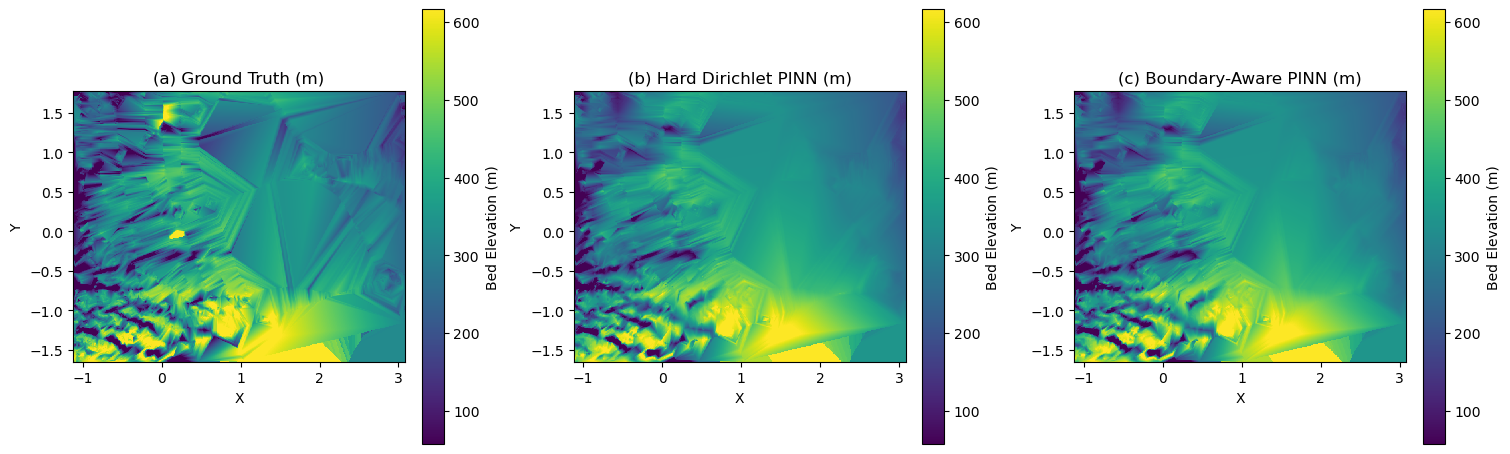

In [ ]:
# === 3-panel maps: GT vs Hard Dirichlet vs Boundary-Aware (meters) ===
import numpy as np, torch, matplotlib.pyplot as plt
from scipy.interpolate import griddata

def _to_np(a): return a.detach().cpu().numpy() if hasattr(a,"detach") else np.asarray(a)

# coords (use physical x,y if you inverted X earlier; otherwise this is fine if already physical)
X_np = _to_np(X_test); x = X_np[:,0].ravel(); y = X_np[:,1].ravel()

# predictions
# boundary-aware (current model)
model.eval()
with torch.no_grad():
    y_pred_soft = model(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy()

# hard-Dirichlet (loaded)
y_pred_hard = np.load("hard_dirichlet_preds.npy")

# inverse-transform to meters
y_true  = _to_np(y_test).reshape(-1,1)
if 'y_scaler' in globals() and y_scaler is not None and globals().get("NORMALIZE_Y", True):
    y_true_m  = y_scaler.inverse_transform(y_true).ravel()
    y_soft_m  = y_scaler.inverse_transform(y_pred_soft.reshape(-1,1)).ravel()
    y_hard_m  = y_scaler.inverse_transform(y_pred_hard.reshape(-1,1)).ravel()
else:
    y_true_m, y_soft_m, y_hard_m = y_true.ravel(), y_pred_soft.ravel(), y_pred_hard.ravel()

# grid for smooth plotting
nx = ny = 500
xi = np.linspace(x.min(), x.max(), nx)
yi = np.linspace(y.min(), y.max(), ny)
Xg, Yg = np.meshgrid(xi, yi)

def interp(z):
    Z = griddata((x,y), z, (Xg,Yg), method="linear")
    m = np.isnan(Z)
    if m.any():
        Z[m] = griddata((x,y), z, (Xg[m],Yg[m]), method="nearest")
    return Z

Zt, Zhard, Zsoft = interp(y_true_m), interp(y_hard_m), interp(y_soft_m)

# shared color scale
vals = np.concatenate([Zt[np.isfinite(Zt)], Zhard[np.isfinite(Zhard)], Zsoft[np.isfinite(Zsoft)]])
vmin, vmax = np.percentile(vals, 2), np.percentile(vals, 98)

fig, axes = plt.subplots(1, 3, figsize=(15, 5.2), constrained_layout=True)
for ax, (title, Z) in zip(axes, [
    ("(a) Ground Truth (m)", Zt),
    ("(b) Hard Dirichlet PINN (m)", Zhard),
    ("(c) Boundary-Aware PINN (m)", Zsoft),
]):
    im = ax.pcolormesh(Xg, Yg, Z, shading="auto", vmin=vmin, vmax=vmax)
    ax.set_title(title); ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_aspect('equal', adjustable='box')
    cb = fig.colorbar(im, ax=ax, shrink=0.85); cb.set_label("Bed Elevation (m)")

plt.show()


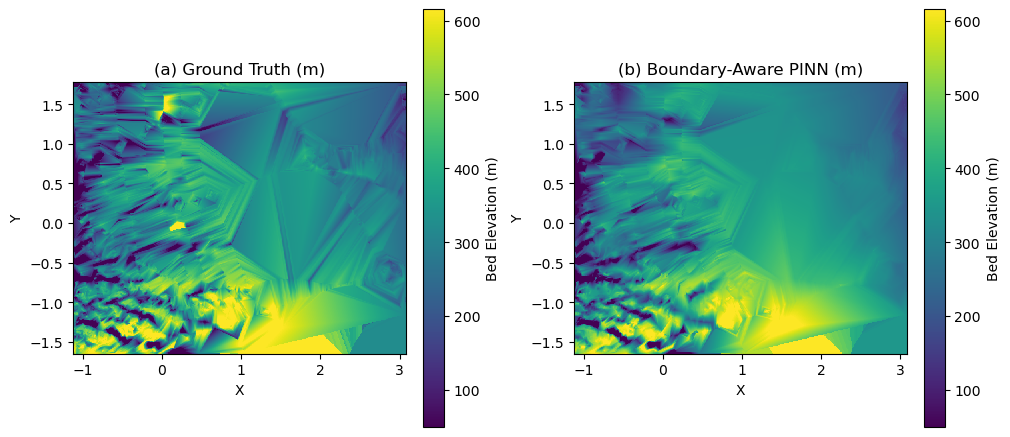

In [ ]:
#supplementary as an extra visualization for comparison === 3-panel maps: GT vs Hard Dirichlet vs Boundary-Aware (meters) ===
import numpy as np, torch, matplotlib.pyplot as plt, os
from numpy import isfinite
from scipy.interpolate import griddata

def _to_np(a):
    return a.detach().cpu().numpy() if hasattr(a, "detach") else np.asarray(a)

# --- coords in physical units
X_np = _to_np(X_test)
x = X_np[:,0].ravel()
y = X_np[:,1].ravel()

# --- ensure predictions exist
model.eval()
with torch.no_grad():
    y_pred_boundary = model(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy()

# --- inverse-transform to meters (if scaler_y available)
y_true  = _to_np(y_test).reshape(-1,1)
y_predB = _to_np(y_pred_boundary).reshape(-1,1)

if 'y_scaler' in globals() and y_scaler is not None:
    y_true_m = y_scaler.inverse_transform(y_true).ravel()
    y_predB_m = y_scaler.inverse_transform(y_predB).ravel()
else:
    y_true_m = y_true.ravel()
    y_predB_m = y_predB.ravel()

# --- if you also have hard Dirichlet version, load its predictions
# (replace with real variable name if different)
# y_pred_hard = np.load("hard_dirichlet_preds.npy")
# y_predH_m   = y_scaler.inverse_transform(y_pred_hard).ravel()

# --- interpolate to grid for smooth plotting
nx = ny = 500
xi = np.linspace(x.min(), x.max(), nx)
yi = np.linspace(y.min(), y.max(), ny)
Xg, Yg = np.meshgrid(xi, yi)

def interp(z):
    Z = griddata((x,y), z, (Xg,Yg), method="linear")
    m = np.isnan(Z)
    if m.any():
        Z[m] = griddata((x,y), z, (Xg[m],Yg[m]), method="nearest")
    return Z

Zt = interp(y_true_m)
Zb = interp(y_predB_m)
# ZH = interp(y_predH_m)  # if you have hard Dirichlet preds

# --- shared color scale
vals = np.concatenate([Zt[isfinite(Zt)], Zb[isfinite(Zb)]])
vmin, vmax = np.percentile(vals, 2), np.percentile(vals, 98)

# --- plot GT vs Boundary-aware (and Hard Dirichlet if available)
fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
for ax, (title,Z) in zip(axes, [
    ("(a) Ground Truth (m)", Zt),
    ("(b) Boundary-Aware PINN (m)", Zb),
    # ("(c) Hard Dirichlet PINN (m)", ZH),
]):
    im = ax.pcolormesh(Xg, Yg, Z, shading="auto", vmin=vmin, vmax=vmax)
    ax.set_title(title); ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_aspect('equal', adjustable='box')
    cb = fig.colorbar(im, ax=ax, shrink=0.85); cb.set_label("Bed Elevation (m)")

plt.show()
